# Mandatory assignment 2: Solow growth model with human capital
Vision: Programming is more than writing code. The ultimate goal of the projects in this course
is that you learn to formulate a programming problem of your own choice, and find your own way
to solve it, and present the results. The bullets below are minimum requirements, but otherwise it is
very much up to you, what yo

* **Step 1: Package import:** The first part of code in our project is the use of libraries with essential packages of panda, numpy and glob which is respectively for data structuring and especially arrays and pathnames. On top of that we import statsmodel

In [1]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
import sympy as sm
sm.init_printing(use_unicode=True)
from scipy import optimize
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from IPython.display import display
from IPython.display import Image
import statsmodels.api as statm
import statsmodels.formula.api as smf
from sympy import symbols, Eq, solve
import turtle

* **Step 2: Datapath and data processing:** The data in table A is from the second edition book "Introducing Advanced Macroeconomics: Growth and Business Cycles" by Peter Birch Sørensen and Hans Jørgen Whitta-Jacobsen. 

In [2]:
#Set datapath 
datapath = "Dataset/"
data = pd.read_excel(datapath + "APPENDIX_TableA_SECOND_ED-7.xls")

#Remove unnecessary rows
data=data[14:-18]
#Remove unnecessary columns
data = data.iloc[:, :-3]

#Mark/select first row
new_header = data.iloc[0]
#all data below first row
data = data[1:] 
#use all data below first row and set column names equal new_header
data.columns = new_header

data.rename(columns = {list(data)[0]:"Country"}, inplace=True)
                                                    
data.head()

14,Country,Code,y03,y60,gy,sK,sH,u,isi,n,Grade,In Sample of 65
15,Luxembourg,LUX,1.73518,0.966286,0.0313231,0.255914,-,-,0.9,0.00836579,A,0
16,USA,USA,1,1,0.017709,0.189912,0.115346,12.049,0.97333,0.0160803,A,1
17,Ireland,IRL,0.971402,0.423321,0.0370255,0.209641,0.125219,9.351,0.76672,0.0100189,A,1
18,Norway,NOR,0.968075,0.761374,0.0232946,0.283681,0.103698,11.848,0.87272,0.0122046,A,1
19,Belgium,BEL,0.906815,0.66365,0.024969,0.224658,0.101057,9.338,0.86572,0.00450328,A,1


We extent the dataset by combining it with data for land per worker and subsoil per worker, which we have downloaded from the World Bank data: Wealth estimates.  

In [3]:
datapath1 = "Dataset/"
#import of natural resources from excel file from the dataset folder
data1 = pd.read_excel(datapath1 + "Natural_resources_the_world_bank.xlsx")
#merging the new natural resource data with the prior country data
data3 = pd.merge(data, data1, on="Code")
#printing the first 50 rows including header sorted with the largest y03 values
data3.head()

,Country_x,Code,y03,y60,gy,sK,sH,u,isi,n,Grade,In Sample of 65,Country_y,Land,Subsoil
0,Luxembourg,LUX,1.73518,0.966286,0.0313231,0.255914,-,-,0.9,0.00836579,A,0,Luxembourg,5600.667027,1988.652571
1,USA,USA,1,1,0.017709,0.189912,0.115346,12.049,0.97333,0.0160803,A,1,United States,4268.678035,8651.206146
2,Ireland,IRL,0.971402,0.423321,0.0370255,0.209641,0.125219,9.351,0.76672,0.0100189,A,1,Ireland,11973.825063,367.476245
3,Norway,NOR,0.968075,0.761374,0.0232946,0.283681,0.103698,11.848,0.87272,0.0122046,A,1,Norway,6372.783293,83250.768105
4,Austria,AUT,0.880988,0.554981,0.0284557,0.24048,0.0951991,8.354,0.86356,0.00244029,A,1,Austria,5163.836552,1007.211843


In [4]:
DataDescribe=data3
#From the dataset we delete unecessary columns
DataDescribe = DataDescribe.drop(["Code", "In Sample of 65", "u", "isi", "Country_y"], 1)
#We do then delete the blank rows of growth in human capital
DataDescribe=DataDescribe[DataDescribe["sH"] != '   -']

#all data columns are defined as floats
DataDescribe["y03"] = DataDescribe.y03.astype(float)
DataDescribe["y60"] = DataDescribe.y60.astype(float)
DataDescribe["gy"] = DataDescribe.gy.astype(float)
DataDescribe["sK"] = DataDescribe.sK.astype(float)
DataDescribe["n"] = DataDescribe.n.astype(float)
DataDescribe["sH"] = DataDescribe.sH.astype(float)
DataDescribe["Land"] = DataDescribe.Land.astype(float)
DataDescribe["Subsoil"] = DataDescribe.Subsoil.astype(float)

#print a descriptive table of maximum observation in y03
print("Table 1: The land with highest growth in income per worker")
max =DataDescribe[DataDescribe.y03 == DataDescribe.y03.max()]
display(max.head())

#print a descriptive table of minimum observation in y03
print("Table 2: The land with the lowest growth in incomer per worker ")
min =DataDescribe[DataDescribe.y03 == DataDescribe.y03.min()]
display(min.head())

Table 1: The land with highest growth in income per worker


,Country_x,y03,y60,gy,sK,sH,n,Grade,Land,Subsoil
1,USA,1.0,1.0,0.017709,0.189912,0.115346,0.01608,A,4268.678035,8651.206146


Table 2: The land with the lowest growth in incomer per worker 


,Country_x,y03,y60,gy,sK,sH,n,Grade,Land,Subsoil
72,Ethiopia,0.023061,0.026356,0.014604,0.035875,0.014008,0.021697,C,2538.656631,50.165113


* **Step 3: Part 1: the Augmented Solow model with Human Capital:** 

We now set up our **augmented Solow model with human capital and natural resources**, which is given by the parameters:

1. $K_t$ is capital per worker
* $L_t$ is labor (with a growth rate on $n$)
* $A_t$ is technology (growing with a rate of $g$)

* $Y_t = K_t^\alpha H_t^\varphi(A_tL_t)^{(1-\alpha)} $ is GDP

We still have the normal framework for a solow model such that **Savings** is a constant fraction of GDP and the production function have a constant return to scale. Moreover, we are going to use the following equations to model our framwork

Dividing the production function by $L_tA_t$ on both sides, gives the production function per effective worker:

5. $y_t = k_t^\alpha h_t^\varphi$

* **Step 4: Steady State predictions:**
We use the equation for physical capital per effective worker in the next period and the equation for human capital per effective worker in the next periode, given by:

6. $k_{t+1} = (1/((1+n)(1+g)))(s_Ky_t+(1-\delta)k_t)$
7. $h_{t+1} = (1/((1+n)(1+g)))(s_Hy_t+(1-\delta)h_t)$

By inserting equation 5 in equation 6 and 7 and divide by , we get:


8. $k_{t+1} = (1/((1+n)(1+g)))(s_Kk_t^\alpha h_t^\varphi+(1-\delta)k_t)$
9. $h_{t+1} = (1/((1+n)(1+g)))(s_Hk_t^\alpha h_t^\varphi+(1-\delta)h_t)$

By withdraw capital from both sides of eq. 8 and 9 we get the solow equation, which is stated below:

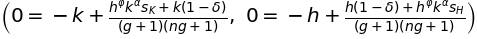

In [5]:
import numpy as np
from scipy.optimize import minimize
import sympy as sm

#Define all variables and parameters as sympy symbols
a = sm.symbols("alpha")
phi = sm.symbols("varphi")
b = sm.symbols("beta")
g = sm.symbols("g")
n = sm.symbols("n")
n = sm.symbols("ng")
y = sm.symbols("y")
d = sm.symbols("delta")
k = sm.symbols("k")
h = sm.symbols("h")
A = sm.symbols("A")
g_y = sm.symbols("g_y")
s_K = sm.symbols("s_K")
s_H = sm.symbols("s_H")
t = sm.symbols("t")

#stating the solow equations of capital and human capitalos with the sm equation function
SolowEq1 = sm.Eq(0,((1/((1+n)*(1+g)))*(s_K*(k**a * (h**phi))+(1-d)*k))-k)
SolowEq2 = sm.Eq(0,((1/((1+n)*(1+g)))*(s_H*(k**a * (h**phi))+(1-d)*h))-h)

#printing the equations
SolowEq1, SolowEq2


We use the above solow equations and solve the system of two equations with two unknowns variables, we get:

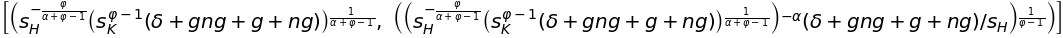

In [6]:
#Define k h as symbols
k, h = symbols('k h')
eq1 = Eq(s_K*k**a*h**phi-(n+g+d+(n*g))*k)
eq2 = Eq(s_H*k**a*h**phi-(n+g+d+(n*g))*h)

#derive the value of k and h in steady state from the abovementioned equations in parameter values
SS = solve((eq1,eq2), (k, h))

#Printing the steady state value for captial and human capital
SS

From above we calculated the expressions for the steady state value for physical capital per effective worker and human capital pr. effective worker. We insert the below parameter values in the steady state expressions and get:

In [7]:
#Stating the variables and function of SS with lambdify
SS1 = sm.lambdify((n, g, s_H, s_K, a, phi, d, h), SS)

#Including the parameters known from macro-theory
SSvalue=SS1(0.01, 0.02, 0.2, 0.2, 0.33, 0.33, 0.05,0.20)

#Printing the numerical steady state values
print(SSvalue)

[(14.696788132394444, 14.696788132394442)]


By using the analytical method we find the steady state values for physical capital and human capital. We now show how to find the steady state value by using the numerical method. 

Conducting a numerical solution instead of a analytical solution

In [8]:
#We define the parameters with their known values for later use (including the steady state value of h)
n = 0.01
g = 0.02
s_H = 0.20
a = 0.33
phi = 0.33
d = 0.05
h = 14.696788132394442

# Defining the steady state as a lambda function
SSN = lambda k: 0 - (1/((1+n)*(1+g)))*((s_H*k**a*h**phi-(n+g+d+n*g)*k))

# using optimize.newton for a numerical solution to our steady state of k
result_SSN = optimize.newton(SSN,x0=100)
result_SSN

In [9]:
#We do then derive the numerical solution for h knowing the value of k
k=14.696788132394438
 
# Defining the steady state as a lambda function
SSN1 = lambda h: 0 - (1/((1+n)*(1+g)))*((s_H*k**a*h**phi-(n+g+d+n*g)*h))

# using optimize.newton for a numerical solution to our steady state of h
result_SSN1 = optimize.newton(SSN1,x0=100)
result_SSN1

* **Step 5: A graphical view of the model:**

The phase diagram illustrates a plot of the transitions equation of human capital and phusical capital. The orange locus gives all combinations of $h_t$ and $k_t$ such that $h_t$ stays unchanged. Likewise, the blue locus gives all the combinations of $h_t$ and $k_t$ such that $k_t$ stays unchanged. From the graph, we see that the steady-state combination, $k^*$ and $h^*$, is where the curves intercept. This interception is exactly the where $k_t = 14.59$ and $h_t=14.69$ as we calculated above. Futhermore this indicates that the steady state fulfills the requirements for balanced growth. Moreover, we see that for every combination of $k_t$ and $h_t$ above the blue curve where $k_{t+1} - k_t > 0$ --> $k_t$ will be increasing and below it, $k_t$ must be decreasing. 
The other curve follows the same dynamics. To the right of the orange curve $h_{t+1} - h_t > 0$, seen from equation PPPP, which means that $h_t$ will be increasing over time while $h_t$ to the left of the orange curve will be decreasing.

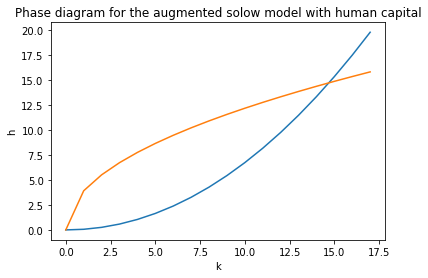

In [10]:
import matplotlib.pyplot as plt
import math  
  
# We define the parameter values 
n = 0.01
g = 0.02
s_K = 0.20
a = 0.33
phi =0.33
s_H =0.20
d =0.05

# Setting the axis range to 18
k = np.array(range(18))

#We state the functions used in the phase diagram
h1 = ((((n+g+d+n*g)/(s_K))**(1/phi))*k**((1-a)/phi))
h2 = (((s_H*k**a)/(n+g+d+n*g))**(1/(1-phi)))

#We plot the x-axis array of k and the functions of h1 and h2
plt.plot(k, h1, h2)
plt.xlabel('k')
plt.ylabel('h')
plt.title('Phase diagram for the augmented solow model with human capital') 
plt.show()

From below we see the exactly same plot as above the only difference is that we now allow the saving rate for physical capital to vary. By simulating the model with a higher saving rate for physical capital, we see that the locus where $k_t$ is unchaged rotates outwards. The economic reason is that a higher saving rate of physical capital means that people are saving more of their income. This leads to a higher saving per worker, which means that capital per capita will increase. When capital per worker increases, income per worker increases as well etc.

In [11]:
#setting a vector with equal linespace
x_vec = np.linspace(0,50,50)

#Defining the phase function of capital and the known variables and parameters
def phasek(k, s_K, a, phi, n):
    return ((((n+0.02+0.05+n*0.02)/(s_K))**(1/phi))*k**((1-a)/phi))

#Defining the phase function of human capital and the the known variables and parameters
def phaseh(k, s_H, a, phi, n):
    return (((s_H*k**a)/(n+0.02+0.05+n*0.02))**(1/(1-phi)))

#setting a optional s_K value in the figure below
def phase_dia(s_K):
#figure size, labels, title and known parameters of phasek and phase h
    fig = plt.figure(figsize=(20,5))
    plt.xlabel('k')
    plt.ylabel('h')
    phasek1=phasek(x_vec, s_K, a, phi, n)
    phaseh1=phaseh(x_vec, s_H, a, phi, n)
    plt.title('Phase diagram for the augmented solow model with human capital')
    #used when you include optional variables
    ax = fig.add_subplot(1,1,1) 
    #plot the two functions and set the axis
    ax.plot(phasek1)
    ax.plot(phaseh1)
    ax.set_xlim([0,60])
    ax.set_ylim([0,30])
#Defining the value of s_K as a widget with a float slider bar with a max of one and default value of 0.2
widgets.interact(phase_dia,
s_K=widgets.FloatSlider(description="$\\ s_K$", min=0, max=1, step=0.01, value=0.20),
                );

interactive(children=(FloatSlider(value=0.2, description='$\\ s_K$', max=1.0, step=0.01), Output()), _dom_clas…

In [12]:
#setting a vector with equal linespace
x_vec = np.linspace(0,50,50)

#Defining the phase function of capital and the known variables and parameters
def phasek(k, s_K, a, phi, n):
    return ((((n+0.02+0.05+n*0.02)/(s_K))**(1/phi))*k**((1-a)/phi))

#Defining the phase function of human capital and the the known variables and parameters
def phaseh(k, s_H, a, phi, n):
    return (((s_H*k**a)/(n+0.02+0.05+n*0.02))**(1/(1-phi)))

#setting a optional s_K value in the figure below
def phase_dia(s_K):
#figure size, labels, title and known parameters of phasek and phase h
    fig = plt.figure(figsize=(20,5))
    plt.xlabel('k')
    plt.ylabel('h')
    phasek1=phasek(x_vec, s_K, a, phi, n)
    phaseh1=phaseh(x_vec, s_H, a, phi, n)
    plt.title('Phase diagram for the augmented solow model with human capital')
    #used when you include optional variables
    ax = fig.add_subplot(1,1,1) 
    #plot the two functions and set the axis
    ax.plot(phasek1)
    ax.plot(phaseh1)
    ax.set_xlim([0,60])
    ax.set_ylim([0,30])
#Defining the value of s_K as a widget with a float slider bar with a max of one and default value of 0.2
widgets.interact(phase_dia,
    s_K=widgets.FloatSlider(description="$\\ s_K$", min=0, max=1, step=0.01, value=0.20),
                );

interactive(children=(FloatSlider(value=0.2, description='$\\ s_K$', max=1.0, step=0.01), Output()), _dom_clas…

* **Step 4: the Augmented Solow Model with Human Capital and Natural resources:** 
We now make a model to investigate the growth in income per worker

We now set up our **augmented Solow model with human capital and natural resources**, which is given by the parameters:

1. $K_t$ is capital per worker
* $L_t$ is labor (with a growth rate on $n$)
* $A_t$ is technology (growing with a rate of $g$)
* $X_t$ is the total amount of land and it does not carry a time subscript since land is in fixed supply
* $R_t$ is the total remaining stock of an exhaustible resource, oil at time t
* $E_t$ is the part of $R_t$ that is used as energy input during periode t (where the exhaustible rate is $s_E$)
* $Y_t = K_t^\alpha H_t^\varphi(A_tL_t)^\beta X^\kappa E_t^\epsilon$ is GDP

We still have the normal framework for a solow model such that **Savings** is a constant fraction of GDP and the production function have a constant return to scale. Moreover, we are going to use the following equations to model our framwork

8. $R_{t+1} = R_t - E_t$
9. $ E_t = s_E R_t$, where $0<s_E<1$

Dividing the production function by $L_t$ on both sides and using equation 9, gives the production function per worker:

10. $y_t = k_t^\alpha h_t^\varphi A_t^\beta (X/L_t)^\kappa ({s_E R_t}/L_t)^\epsilon $
11. $y_t = k_t^\alpha h_t^\varphi A_t^\beta x_t^\kappa e_t^\epsilon $
By taking logs on both sides we get:
11. $ln(y_t) = \alpha ln(k_t) +\varphi ln(h_t)+ \beta ln(A_t)- \kappa (ln(L_t)-ln(L_{t-1}))+ \epsilon (((ln(R_t)-ln(R_{t-1}))-(ln(L_t)-ln(L_{t-1}))) = \alpha ln(k_t) +\varphi ln(h_t)+ \beta ln(A_t)- (\kappa+\epsilon) (ln(L_t)-ln(L_{t-1}))+ \epsilon (ln(R_t)-ln(R_{t-1})) $

By combinig equation 8 and 9, we get that $ R_{t+1} = R_t - s_E R_t <=> (R_{t+1}/R_t) = s_E + 1 $, and use that $ln(R_t)-ln(R_{t-1})=-ln(s_E+1) =-s_E$, we get that

13. $ln(y_t) = \alpha ln(k_t) +\varphi ln(h_t)+ \beta ln(A_t)- (\kappa+\epsilon) n- \epsilon s_E $

we know use the standard approximation that logs differences is a growth rate approximation. Therefore, calculate the time differences on both sides which gives:

14. $ln(y_t)-ln(y_{t-1}) = \alpha (ln(k_t)-ln(k_{t-1})) +\varphi (ln(h_t)-ln(h_{t-1}))+ \beta (ln(A_t)-ln(A_{t-1}))- (\kappa+\epsilon) n- \epsilon s_E$

We use the approximation that the gowth rate for output per worker is $g_y$, the growth rate for technology is g, the growth rate for human capital per worker is $g_h$ and the growth rate in capital per worker is $g_k$. This gives us the following equation:

15. $g_y = \alpha g_k +\varphi g_h+ \beta g- (\kappa+\epsilon) n- \epsilon s_E$
 

We know from the solow model that the two capital/output ratios is constant in steady state, which is why we use the approximation that both capital and human capital grow at the same rate as $y_t$: $g_y = g_k =g_h$. This gives us the following model

16. $g_y = \beta / {(1-\alpha-\varphi)} g - {(\kappa+\epsilon)n} / {(1-\alpha-\varphi)} - \epsilon / {(1-\alpha-\varphi)} s_E$

we now use that the solow model with human capital and natural resources exhibit constant return to scale, which gives us

17. $g_y = \beta / {(\beta+\kappa+\epsilon)} g - {(\kappa+\epsilon)n} / {(\beta+\kappa+\epsilon)} - \epsilon / {(\beta+\kappa+\epsilon)} s_E$

We now have our equation 17, which can tell us how large growth rate in GDP each country have depending on the parameters. Therefore, we will first find the parameter values before we continue by finding the growth rate for GDP for different values for growth rate for population and growth rate for technology 



* **Step 4: finding parameter values for all parameters that are included in our equation 17:**

We use equation (37) from page 205 in the book "Introducing  Advanced Macroeconomics - Growth and Business Cycles" by Peter Birk Sørensen and Hans Jørgen Whitta-Jacobsen and augmenting it with human capital. We then get:

18. $ln(y_t^*) = \beta / {(\beta+\kappa+\epsilon)} ln(A_t) + \epsilon / {(\beta+\kappa+\epsilon)} ln(s_E) + \alpha / {(\beta+\kappa+\epsilon)} [ln(s_K)-ln(n+0.062)]+ \varphi / {(\beta+\kappa+\epsilon)} [ln(s_H)-ln(n+0.062)] + \kappa / {(\beta+\kappa+\epsilon)} ln({X/L_t})+ \epsilon / {(\beta+\kappa+\epsilon)} ln({R_t/L_t}) $

Which gives us the following regression equation:

18. $ln(y_{00}^i) = \gamma_0 + \gamma_1 [ln(s^i_K)-ln(n^i+0.062)]+ \gamma_2 [ln(s^i_H)-ln(n^i+0.062)] + \gamma_3 ln({X/L^i})_{00}+  \gamma_4 ln({R^i/L^i})_{00} $





In [13]:
#Linear estimation from the dataset imported in cell 2
#Restructuring the values into log format
logy60=np.log(DataDescribe["y60"])
logy03=np.log(DataDescribe["y03"])
logn1 =np.log(DataDescribe["n"]+0.075)
logsK1=np.log(DataDescribe["sK"]) - logn1
logsH1=np.log(DataDescribe["sH"]) - logn1
logland =np.log(DataDescribe["Land"])
logsubsoil =np.log(DataDescribe["Subsoil"]) 

# Fit regression model (using the natural log of one of the regressors) from the dataframe called datadescripe 
results = smf.ols("logy03 ~ logsK1 + logsH1 + logland + logsubsoil", data=DataDescribe).fit()

# Inspect the results of log(y03) with the regressors logsK1, logsH1, logland, logsubsoil
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 logy03   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     47.14
Date:                Fri, 10 May 2019   Prob (F-statistic):           2.08e-18
Time:                        22:05:02   Log-Likelihood:                -62.695
No. Observations:                  69   AIC:                             135.4
Df Residuals:                      64   BIC:                             146.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6310      1.200     -2.193      0.0

From the regression table above we see that the variables Land and Subsoil are insignificant, meaning we cannot use the coefficients for land per worker and subsoil per worker to estimate $/epsilon$ and $/kappa$. Therefore, we use the coefficients provided by   They have a P-value on 0.372 and 0.389 respectively. $s_K$ and $s_H $depend positively on the growth in 2003 as we expected. That is why we use the koefficient values from provided by Hans Jørgen and Peter birk in the macroeconomic book. The other koefficient is calculated below by using the exrepresson from the same book

We estimate the parameters

* $\alpha = \gamma_1/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$
* $\varphi = \gamma_2/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$
* $\kappa = \gamma_3/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$
* $\epsilon = \gamma_4/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$

By inserting the estimated values we get

* $\alpha = 0.3933/{(1+0.3933+0.8993+0.1283+0.0301)} = 0.16 $
* $\varphi = 0.8993/{(1+0.3933+0.8993+0.1283+0.0301)} = 0.37 $
* $\kappa = 0.1283/{(1+0.3933+0.8993+0.1283+0.0301)} = 0.05 $
* $\epsilon = 0.0301/{(1+0.3933+0.8993+0.1283+0.0301)}= 0.01 $

We assume that the shares for raw labour and human capital is equal to 0.6, meaning that $\beta = 0.23$
We now continue our modelproject with the shares (the shares for land and oil are not siginficant so we continue with the shares from the book by Hans Jørgen and Peter Birk:

* $\alpha = 0.2 $
* $\varphi = 0.3 $
* $\kappa = 0.1 $
* $\epsilon = 0.1$
* $\beta = 0.3$

we insert the parameters in the growth eq.

* $g_y = 0.3/{(0.3+0.1+0.1)}g - {(0.2)n} / {(0.3+0.1+0.1)} - 0.1 / {(0.3+0.1+0.1)} 0.005$ 
* $g_y = 0.6g - 0.4n - 0.001$

$g_y = \beta / {(\beta+\kappa+\epsilon)} g - {(\kappa+\epsilon)n} / {(\beta+\kappa+\epsilon)} - \epsilon / {(\beta+\kappa+\epsilon)} s_E$

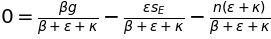

In [14]:
#Defining the symbols from sympy
b = sm.symbols("beta")
g = sm.symbols("g")
n = sm.symbols("n")
k = sm.symbols("kappa")
e = sm.symbols("epsilon")
g_y = sm.symbols("g_y")
s_K = sm.symbols("s_K")
s_H = sm.symbols("s_H")
s_E = sm.symbols("s_E")

#Stating the growth equation as a sympy equation 
growth = sm.Eq(0, (b/(b+k+e)*g)-(k+e)*n/(b+k+e)-e/(b+k+e)*s_E)
#Print the equation
growth
    

In [15]:
#solve when the growth rate is zero
growth1 = sm.solve(growth, g)
#Print the solution of g
growth1

In [16]:
#Delete earlier values of n, e, s_E, b and k for a new estimation
del n
del e
del s_E
del b
del k

#Define the new symbols with sympy
b = sm.symbols("beta")
g = sm.symbols("g")
n = sm.symbols("n")
s_E = sm.symbols("s_E")
e = sm.symbols("epsilon")
k = sm.symbols("kappa")

#Define the growthh function with the variables and parameters n, e, s_E, b, k.
def growthh(n, e, s_E, b, k):
    return ((e*n+e*s_E+k*n)/b)

#setting a vector with equal linespace
x_vec1 = np.linspace(0,50,50)

#Define the plot settings with the variables of s_E, b, e, k.
def dia(s_E, b, e, k):
#Plot size, labels, and title
    fig = plt.figure(figsize=(20,5))
    plt.xlabel('n')
    plt.ylabel('g')
    ax=plt.gca()
    ax.grid(True)
    #Setting the plotted function as the growthh function with the unknown variables of x_vec1, s_E, e, b and k
    growthh1=growthh(x_vec1, s_E, e, b, k)
    plt.title('growth')
    ax = fig.add_subplot(1,1,1) 
    ax.plot(growthh1);
    ax.set_xlim([0,0.1])
    ax.set_ylim([0,0.1])

#the optional variables are then defined as float sliders with defautl values
widgets.interact(dia, 
s_E=widgets.FloatSlider(description="$\\ s_E$", min=0, max=1, step=0.01, value=0.03),
b=widgets.FloatSlider(description="$ \\beta $", min=0, max=1, step=0.01, value=0.66),
e=widgets.FloatSlider(description="$ e $", min=0, max=1, step=0.01, value=0.1),
k=widgets.FloatSlider(description="$ \kappa $", min=0, max=1, step=0.01, value=0.1),
  
                );


interactive(children=(FloatSlider(value=0.03, description='$\\ s_E$', max=1.0, step=0.01), FloatSlider(value=0…

This graph plots the growth in technology in the y-axis and population growth on the x-axis. A long the line we have that the long run growth rate in income per worker is exactly zero. If we are above the line we have that the growth rate en technology is high enought to compensate from the growth drag form land, oil and population. Moreover, the if we are below the line we have that the growth rate in technology is not high enought to compensate from the growth drag meaning that the long run growth rate in income per worker will be negativ. We can move the interactive graph and see that a higher epsilon and kappa will lead to a higher growth drag meaning that the growth rate in technology have to be higher to compensate from the growth drag.